# 폐렴 진단
* nomal / Pneumonia 폐렴인지 아닌지 분류하기(binary classification)

|평가문항|상세기준|
|---|---|
|1. 의료영상을 처리하는 CNN 기반 딥러닝 모델이 잘 구현되었다.|모델 학습이 안정적으로 수렴하는 것을 시각화를 통해 확인하였다.|
|2. 데이터 준비, 모델구성 등의 과정의 다양한 실험이 체계적으로 수행되었다.|regularization, augmentation 등의 기법의 사용 여부에 따른 모델 성능 측정이 ablation study 형태로 체계적으로 수행되었다.|
|3. 실습코드를 잘 개선하여 폐렴 검출 정확도가 추가로 향상되었다.|Accuracy 기준 85%에 도달하였다.|

# 패키지 및 라이브러리 불러오기

In [1]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Step 1. 실험환경 Set-pu

In [2]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE

# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*'
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 16
EPOCHS = 25

# Step 2. 데이터 준비하기

In [3]:
# 데이터 가져오기
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print('-'*30)
print('train_filenames :',len(train_filenames))
print('val_filenames :',len(val_filenames))

5216
624
16
------------------------------
train_filenames : 4185
val_filenames : 1047


* train_size : filenames * 0.8보다 작거나 같은 값을 가장 큰 floor를 반환
 * train, val에 slice하여 데이터를 나누었음 

In [4]:
# 파일 경로를 통한 정상 이미지와 폐렴 이미지 구분
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

print('--'*40)

# NOMAL(정상) 확인
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")

# PNEUMONIA(폐렴) 확인
COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal image path
/aiffel/aiffel/chest_xray/data/train/NORMAL/NORMAL2-IM-0627-0001.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person569_bacteria_2360.jpeg
--------------------------------------------------------------------------------
Normal images count in training set: 1072
Pneumonia images count in training set: 3113


In [5]:
# 배치처리 작업의 효율을 위한 tf.data 사용
# 숫자 형태의 배열로 변환
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


In [6]:
# 라벨 데이터 생성 함수
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep) # '/'을 기준으로 나눈다.
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

In [7]:
# train / validation set 만들기
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
print(train_ds)
print(val_ds)

# 라벨링 확인
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

# data agumentation 
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    return image,label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,                 # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat() 
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE) 

    return ds

# data agumentation 적용
train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)
print('agumentation train', train_ds)
print('agumentation validation', val_ds)

<ParallelMapDataset shapes: ((180, 180, 3), ()), types: (tf.float32, tf.bool)>
<ParallelMapDataset shapes: ((180, 180, 3), ()), types: (tf.float32, tf.bool)>
Image shape:  (180, 180, 3)
Label:  False
agumentation train <PrefetchDataset shapes: ((None, 180, 180, 3), (None,)), types: (tf.float32, tf.bool)>
agumentation validation <PrefetchDataset shapes: ((None, 180, 180, 3), (None,)), types: (tf.float32, tf.bool)>


* repeat() : epoch을 진행하면서 여러 번 데이터셋 사용, 자동으로 데이터를 맞춤 
* prefetch() :학습 데이터를 나눠서 읽고 다음 순번의 데이터를 CPU에서 준비할 수 있음.

In [8]:
# test set 만들기
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


* tf.data.Dataset.list_files
 * 클래스 디렉토리를 받아 하위에 존재하는 이미지 경로를 반환
* tf.data.experimental.cardinality
 * data의 카디널리티를 반환(전체 행에 대한 특정 컬럼의 중복수치를 나타내는 지표)
  * scalar tf.int64.Tensor를 나타냄. 
  * 카디널리티가 무한하면 INFINITE_CARDINALITY를 반환
  * 카디널리티를 알 수 없다면 UNKNOWN_CARDINALITY를 반환

# Step 3. 데이터 시각화

* math.ceil : 실수를 입력하면 올림하여 정수로 반환

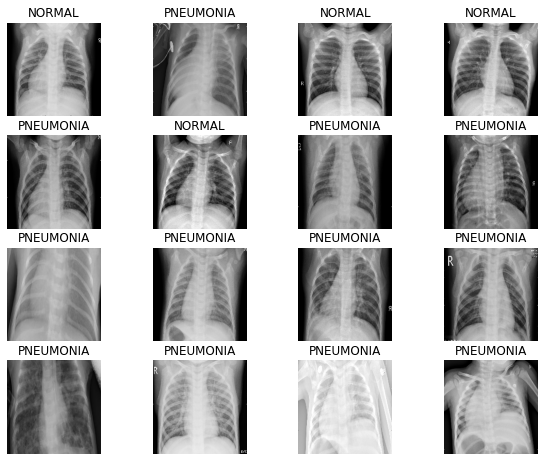

In [9]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(5,math.ceil(BATCH_SIZE/5),n+1) 
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

# Step 4. CNN 모델링

In [10]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block


def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block


def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.4),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.4),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

* SeparableConv2D
 * 기존의 Conv2D보다 빠른 계산을 지원
 * 깊이있는 공간 컨볼루션과 출력 채널을 혼합하는 포인트 컨볼루션을 수행

# Step 5. 데이터 imbalance 처리

In [11]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.95
Weight for PNEUMONIA: 0.67


# Step 6. 모델 훈련

In [12]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [13]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 54s 132ms/step - loss: 0.6334 - accuracy: 0.6421 - precision: 0.8896 - recall: 0.5924 - val_loss: 0.6145 - val_accuracy: 0.7356 - val_precision: 0.7356 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 33s 126ms/step - loss: 0.3362 - accuracy: 0.8496 - precision: 0.9619 - recall: 0.8333 - val_loss: 1.1412 - val_accuracy: 0.7375 - val_precision: 0.7375 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 33s 127ms/step - loss: 0.2769 - accuracy: 0.8827 - precision: 0.9730 - recall: 0.8666 - val_loss: 0.3934 - val_accuracy: 0.7798 - val_precision: 0.7698 - val_recall: 1.0000
Epoch 4/25
261/261 [==============================] - 33s 126ms/step - loss: 0.2616 - accuracy: 0.8907 - precision: 0.9709 - recall: 0.8803 - val_loss: 0.3123 - val_accuracy: 0.8769 - val_precision: 0.9969 - val_recall: 0.8351
Epoch 5/25
261/261 [==============================] - 33s 126ms/step - loss: 0.2242 - accura

In [14]:
# test set으로 확인
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 3s 74ms/step - loss: 0.5165 - accuracy: 0.8686 - precision: 0.8850 - recall: 0.9077
Loss: 0.5164605975151062,
Accuracy: 0.8685897588729858,
Precision: 0.8849999904632568,
Recall: 0.9076923131942749


# Step 7. 결과 확인과 시각화

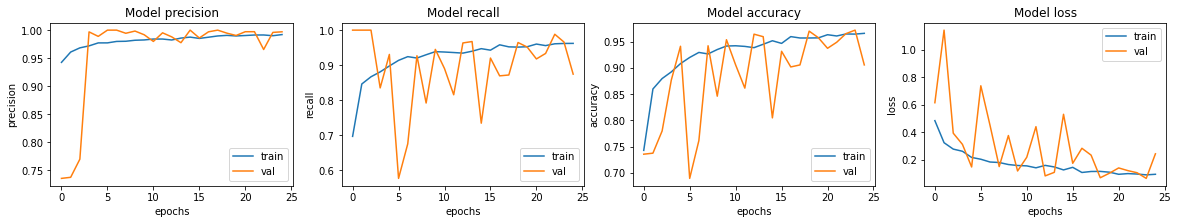

In [15]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

* map을 통해 num_parallel_calls에 tf.data.experimental.AUTOTUNE을 사용하면 다중 CPU를 사용해서 데이터 추출 프로세스를 병렬화하기 위해서 사용(시스템의 다중 코어를 활용하기 위해 다중 스레드를 생성)
 * 전처리를 병렬화
 * 현재 가용 CPU(하드웨어 상의 CPU)보다 높은 값을 설정하면 스케쥴링이 비효율적으로 느려짐
* tf.io.gfile.glob : 주어진 패턴과 일치하는 파일 목록을 반환
* math.floor : x보다 작거나 같은 가장 큰 정수인 x의 floor를 반환.

* 1차 시도
 * batch_size = 16, epoch = 25
 * test_accuracy = 85%, recall = 94%


* 2차 시도
 * batch_size = 16, epoch = 25
 * test_accuracy = 83%, recall = 94%
 * 동일한 Hyperparameter에서 한번 더 시도


* 3차 시도
 * batch_size = 8, epoch = 25
 * test_accuracy = 67%, recall = 100%
 * batch_size 줄여서 확인
 
 
* 4차 시도
 * batch_size = 32, epoch = 25
 * test_accuracy = 69%, recall = 100%
 * batch_size를 올려서 확인
 
 
* 5차 시도
 * batch_size = 16, epoch = 25, dropout = 0.4
 * test_accuracy = 86%, recall = 90%
 * batch_size = 16, dropout 0.2 -> 0.4 변경
  
  
* 기존의 모델로는 shuffle 되는 데이터에 따라 3~5%의 accuracy 차이를 보임. 같은 setting 값으로 처음 시도에는 acc 85% 나왔으나 두 번째 시도에서 85% 이하로 떨어진 것을 보아 shuffle 되는 상황에 따라 달라지는 것으로 판단.
* data agumenation을 한다면 HSV(색상, 채도, 명도)를 바꿔서 데이터를 증가 시키는 방법이 있을 것 같음.
* 만약에 위, 아래 반전시킨 데이터를 추가 한다면 model은 사람과 다른 패턴을 인식하기 때문에 학습하는데 더 효율적일 수 있을지 의문이 생김 
* tf.image.random_flip_left_right를 확인해보면 매번 학습할 때마다 랜덤하게 데이터를 모델에 넣을 때 좌·우가 바뀌어서 들어가기 때문에 성능이 차이가 날 것으로 판단 됨.
 * 데이터를 물리적으로 늘려서 추가하는 것이 아니라 존재하는 데이터로만 Transform 한다고 보면 되는데 어째서 augmentation 인지 의문이 생김
* https://gaussian37.github.io/dl-concept-order_of_regularization_term/
 * 이 블로그의 설명에 따르면 Convolution - Batch Normalization - Activation - Dropout - Pooling 순서로 BN과 dropout을 같이 적용했을 때 성능이 잘 나왔다고 함.
 * 노드에서도 설명을 했듯이 BN는 dropout을 대체 할 수 있으며 같이 쓰면 성능이 안좋다기 보다 상황에 따라서 달라질 수 있음을 블로그에서도 설명하고 있음.(이를 이론과 실적용의 차이로 해석)
 * batch nomalization과 dropout의 위치를 바꿔서 구성해본다면 좋은 성능을 보여줄 수 있는 모델을 만들 수 있을 것으로 예상